# Assignment Day 9

## Team members:
- Samuel Nebgen s6sanebg@uni-bonn.de
- Muhammad Humza Arain s27marai@uni-bonn.de
- Julian Meigen s82jmeig@uni-bonn.de

## 18.09.2025

Contributions were made by all team members in around the same amount, either based on discussions or coding.

# Task 1: Load the Mutagenicity dataset from TUDatasets (https://chrsmrrs.github.io/datasets/docs/datasets/)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
from torch_geometric.datasets import TUDataset

In [ ]:
save_data_path = os.path.join("..", "data", "interim")
dataset = TUDataset(root=save_data_path, name="Mutagenicity", use_node_attr=True, use_edge_attr=True)

In [ ]:
len(list(dataset))

4337

# Task 2: Visualize the data by drawing the molecule graph of one sample.


### Using the predefined Code

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g

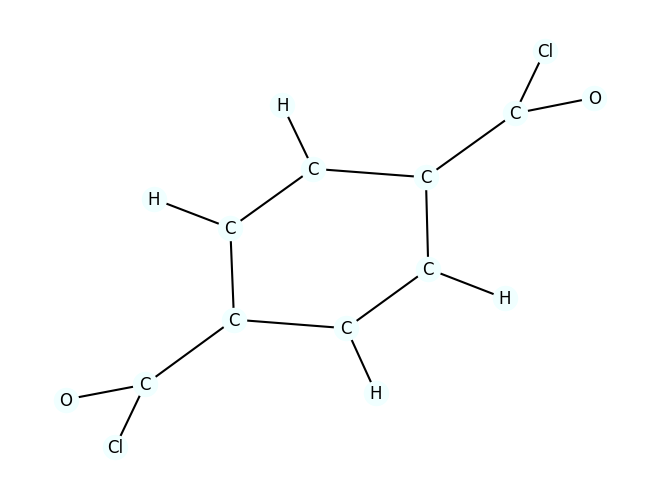

In [ ]:
G = to_molecule(dataset[0])
draw_molecule(G)

### Only using Netwokx

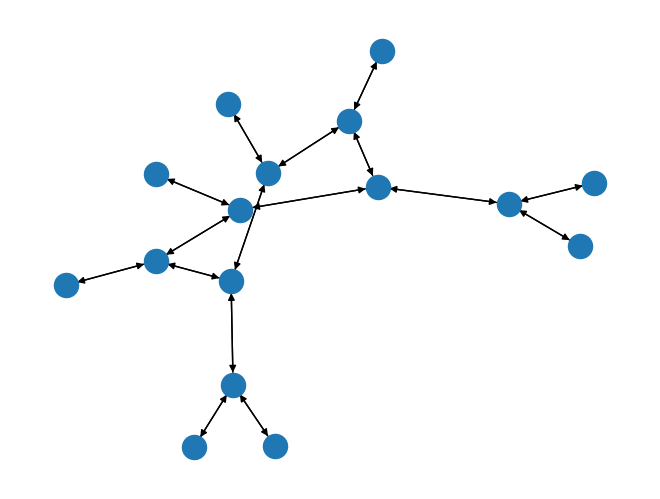

In [ ]:
nx.draw(G)

# Task 3: Train a GNN model with 5 convolutional layers with pytorch-geometric.


## a. Define the model.


In [ ]:
dataset[0]

Data(edge_index=[2, 32], x=[16, 14], edge_attr=[32, 3], y=[1])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import NNConv, global_mean_pool


class ConvGNN(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels, edge_dim, dropout_rate_1=0.5, dropout_rate_2=0.5):
        super(ConvGNN, self).__init__()

        # A small neural networ to map edge features into weight matrices, which can be used by NNConv to include edge feature types into the NN.
        edge_nn_in = nn.Sequential(
            nn.Linear(edge_dim, 6),
            nn.ReLU(),
            nn.Linear(6, in_channels * hidden_dim)
            )
        edge_nn_hidden = nn.Sequential(
            nn.Linear(edge_dim, 6),
            nn.ReLU(),
            nn.Linear(6, hidden_dim * hidden_dim)
            )


        self.conv1 = NNConv(in_channels, hidden_dim, edge_nn_in) # Use NNConv instead of GCNConv to include edge features
        self.conv2 = NNConv(hidden_dim, hidden_dim, edge_nn_hidden)
        self.conv3 = NNConv(hidden_dim, hidden_dim, edge_nn_hidden)
        self.conv4 = NNConv(hidden_dim, hidden_dim, edge_nn_hidden)
        self.conv5 = NNConv(hidden_dim, hidden_dim, edge_nn_hidden)
        self.dropout_1 = nn.Dropout(p=dropout_rate_1)
        self.dropout_2 = nn.Dropout(p=dropout_rate_2)

        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, out_channels)


    def forward(self, graph):
        x = graph.x
        edge_index = graph.edge_index
        edge_weights = graph.edge_attr

        x = self.conv1(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.dropout_1(x)

        x = self.conv3(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.conv4(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.dropout_2(x)

        x = self.conv5(x, edge_index, edge_weights)
        x = F.relu(x)

        # Pooling the node features to obtain graph-level representation, because we have a graph classification problem
        x = global_mean_pool(x, graph.batch) # graph.batch should give the batch index of the node if we use a dataloader. Therefore its a Molecule Classification and not a batch classification
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return torch.softmax(x, dim=1)

## b. Define the train and test function.


In [ ]:
def train(model, optimizer, train_dataloader, device):
    model.train()

    loss_all = 0
    for data in train_dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataloader.dataset)


def test(model, test_dataloader, device):
    model.eval()

    correct = 0
    for data in test_dataloader:
        data = data.to(device)
        output = model(data)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(test_dataloader.dataset)

## c. Train the model for 100 epochs.


### Split Data

In [ ]:
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

In [ ]:
# labels for molecules, which are used for stratified splitting
y = dataset.data.y
print(len(y))

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42, stratify=y)

/Users/julianmeigen/Uni/2_Semester/ML_BlockCourse/ML-handson/.venv/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


4337


In [ ]:
# Load the molecules into toech geometrics dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

### Train and Test

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
edge_dim = dataset[0].edge_attr.shape[1] # Number of edge features (here: 3)
in_channels = dataset.num_node_features # Number of node features (here: 14)
hidden_dim = 32 # Hyperparameter: Dimension of hidden layers
out_channels = dataset.num_classes # Output dimension (here: 1, because binary classification)
dropout_rate_1 = 0.5 # Hyperparameter: Dropout rate after 2nd conv layer
dropout_rate_2 = 0.5 # Hyperparameter: Dropout rate after 4th conv layer

GCNConv_model = ConvGNN(in_channels=in_channels, hidden_dim=hidden_dim, out_channels=out_channels, edge_dim=edge_dim, dropout_rate_1=dropout_rate_1, dropout_rate_2=dropout_rate_2).to(device)
optimizer = torch.optim.Adam(GCNConv_model.parameters(), lr=0.001)

for epoch in range(1, 101):
    loss = train(GCNConv_model, optimizer, train_dataloader, device)
    train_acc = test(GCNConv_model, train_dataloader, device)

    test_acc = test(GCNConv_model, test_dataloader, device)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: -0.5540, Train Acc: 0.5546, Test Acc: 0.5530
Epoch: 002, Loss: -0.5906, Train Acc: 0.6662, Test Acc: 0.6187
Epoch: 003, Loss: -0.6383, Train Acc: 0.6780, Test Acc: 0.6463
Epoch: 004, Loss: -0.6671, Train Acc: 0.6890, Test Acc: 0.6751
Epoch: 005, Loss: -0.6775, Train Acc: 0.6910, Test Acc: 0.6671
Epoch: 006, Loss: -0.6782, Train Acc: 0.7112, Test Acc: 0.6855
Epoch: 007, Loss: -0.6960, Train Acc: 0.7126, Test Acc: 0.6982
Epoch: 008, Loss: -0.6975, Train Acc: 0.7224, Test Acc: 0.7039
Epoch: 009, Loss: -0.6883, Train Acc: 0.7195, Test Acc: 0.6878
Epoch: 010, Loss: -0.7091, Train Acc: 0.7328, Test Acc: 0.7051
Epoch: 011, Loss: -0.7245, Train Acc: 0.7325, Test Acc: 0.7177
Epoch: 012, Loss: -0.7124, Train Acc: 0.7437, Test Acc: 0.7235
Epoch: 013, Loss: -0.7311, Train Acc: 0.7472, Test Acc: 0.7258
Epoch: 014, Loss: -0.7357, Train Acc: 0.7593, Test Acc: 0.7281
Epoch: 015, Loss: -0.7426, Train Acc: 0.7651, Test Acc: 0.7293
Epoch: 016, Loss: -0.7341, Train Acc: 0.7703, Test Acc:

# Task 4: Explain the predictions using the captum package (https://captum.ai/) with the method Integrated Gradients.


## a. Familiarize yourself with the method, and the captum package (https://captum.ai/docs/extension/integrated_gradients). Summarize the method in your own words (5-8sentences).


Captums Integrated Gradients is a technique used to interpret the importance that individual input features have on a model's predictions.  
The technique works by comparing a models output for a given, randomly chosen input to a so called baseline input, which is typically a zeroed out version of the original input (e.g. a black image for image data, uninformative Graph with no Edges).  
The method computes the gradients of the model's output with respect to the input features, and integrates these gradients along a path from the baseline to the actual input.  
This means, that at every step along the path, the gradient is calculated and summed up to get a total importance score for each feature.  
At the end, the result is an attribution score for each input feature, showing how much that feature contributed to the difference between the model’s output at the baseline and the model’s output at the real input.


https://arxiv.org/pdf/1703.01365


## b. Calculate the attributions of the input to the model’s predictions.


In [ ]:
import torch
import numpy as np
from captum.attr import IntegratedGradients, Saliency
from collections import defaultdict

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Forward function for Captum
def model_forward(edge_mask, graph):
    # edge_mask is a 1D tensor with shape [num_edges]
    masked_graph = graph.clone()
    masked_graph.edge_attr = graph.edge_attr * edge_mask.view(-1, 1)
    out = GCNConv_model(masked_graph)
    return out
def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_attr.shape[0], requires_grad=True).to(device)

    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(inputs=input_mask,
                            target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_attr.shape[0])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(inputs=input_mask,
                                  target=target,
                                  additional_forward_args=(data,))
    else:
        raise ValueError('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

## c. Visualize your results. Which were the most important inputs for a prediction?


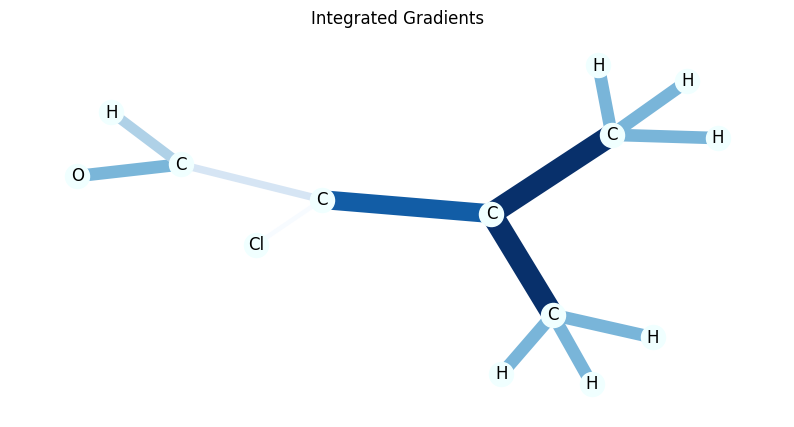

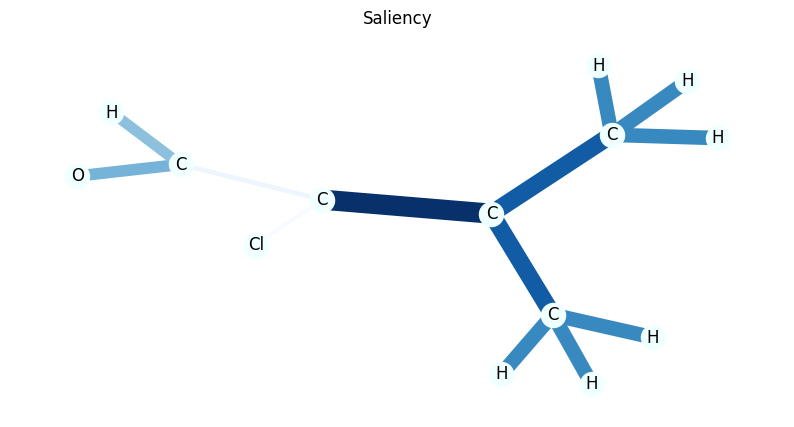

In [ ]:

# Aggregate edge importance
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in zip(edge_mask, *data.edge_index):
        u, v = int(u), int(v)
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

# Usage example
import random
data = random.choice([t for t in test_dataset if not t.y.item()])

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(to_molecule(data), edge_mask_dict)


# Task 5: Use the GNNExplainer from pytorch-geometric to explain the model’s predictions.


## a. Familiarize yourself with the method (https://arxiv.org/pdf/1903.03894 ). Summarize the method in your own words (5-8 sentences).


If we have a trained model and a set of predictions. The GNNEXPLAINER will generate an explanation by identifying a
subgraph of the computation graph and a subset of node features that are most influential for the model prediction. In the case of explaining a set of predictions, GNNEXPLAINER will aggregate individual explanations in the set and automatically summarize it with a prototype.

Importance will be derived through Mutual Information.

In my words: The GNNExplainer get one input graph as inputs and its prediction from a already trained model. It now freezes that model and represents each Node and feature in a Graph with a mask ranging from 0-1, which represents the importantance of that edge or node in getting the prediction. Over multiple Epochs, it now traines these node and edges weights with the goal to get a similiar prediction as before. Therefore it will find edges/nodes which are important for the prediciton and some shich are not. --> Generates A subgraph which is most important to get prediction of input.

## b. Visualize your results. Choose an interesting prediction and show the most important input.

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn import GCNConv

save_data_path = os.path.join("..", "data", "interim")
train_dataset
data = train_dataset[0]


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for _ in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)
node_index = 10
explanation = explainer(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance.png'
explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")